### Notebook for the cell-cell interactions analysis on undifferentiated fetal cells with `liana Tensor-Cell2cell`

- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Created date:** 21st May 2024
- **Last modified date:** 21st May 2024

### Import packages

In [40]:
import pandas as pd
import scanpy as sc
import plotnine as p9
import numpy as np

import torch

import liana as li
import cell2cell as c2c
import decoupler as dc # needed for pathway enrichment

import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

%matplotlib inline

In [41]:
use_gpu = True

if use_gpu:
    import torch
    import tensorly as tl

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    if device == "cuda:0":
        tl.set_backend('pytorch')
else:
    device = "cpu"

device

'cuda:0'

In [42]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [43]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi = 300, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'png')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
brotli                      1.1.0
cell2cell                   0.7.4
certifi                     2023.11.17
cffi                        1.16.0
charset_normalizer          3.3.2
comm                        0.1.4
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
decoupler                   1.6.0
defusedxml                  0.7.1
docrep                      0.3.2
exceptiongroup              1.1.3
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
get_annotations             NA
h5py                        3.10.0
idna                        3.4
importl

### Load data

In [44]:
input = '/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_undifferentiated_cells/Fetal_undifferentiated_cells.h5ad'
adata = sc.read_h5ad(input)

In [45]:
X_is_raw(adata)

True

### Indicate output directory


In [46]:
output_dir = '/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_undifferentiated_cells/liana_results'

### Normalize and log-transform data

In [47]:
adata_raw = adata.copy()
sc.pp.normalize_total(adata, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['APOA1', 'APOC3', 'DEFA5', 'DEFA6', 'FTL', 'GUCA2A', 'GUCA2B', 'LCN15', 'MALAT1', 'MT-ATP6', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1', 'MT-ND3', 'MT-ND4', 'MT-ND4L', 'MT-ND6', 'MT1G', 'MTRNR2L12', 'NEAT1', 'PLA2G2A', 'REN', 'SST', 'TFF3']
    finished (0:00:00)


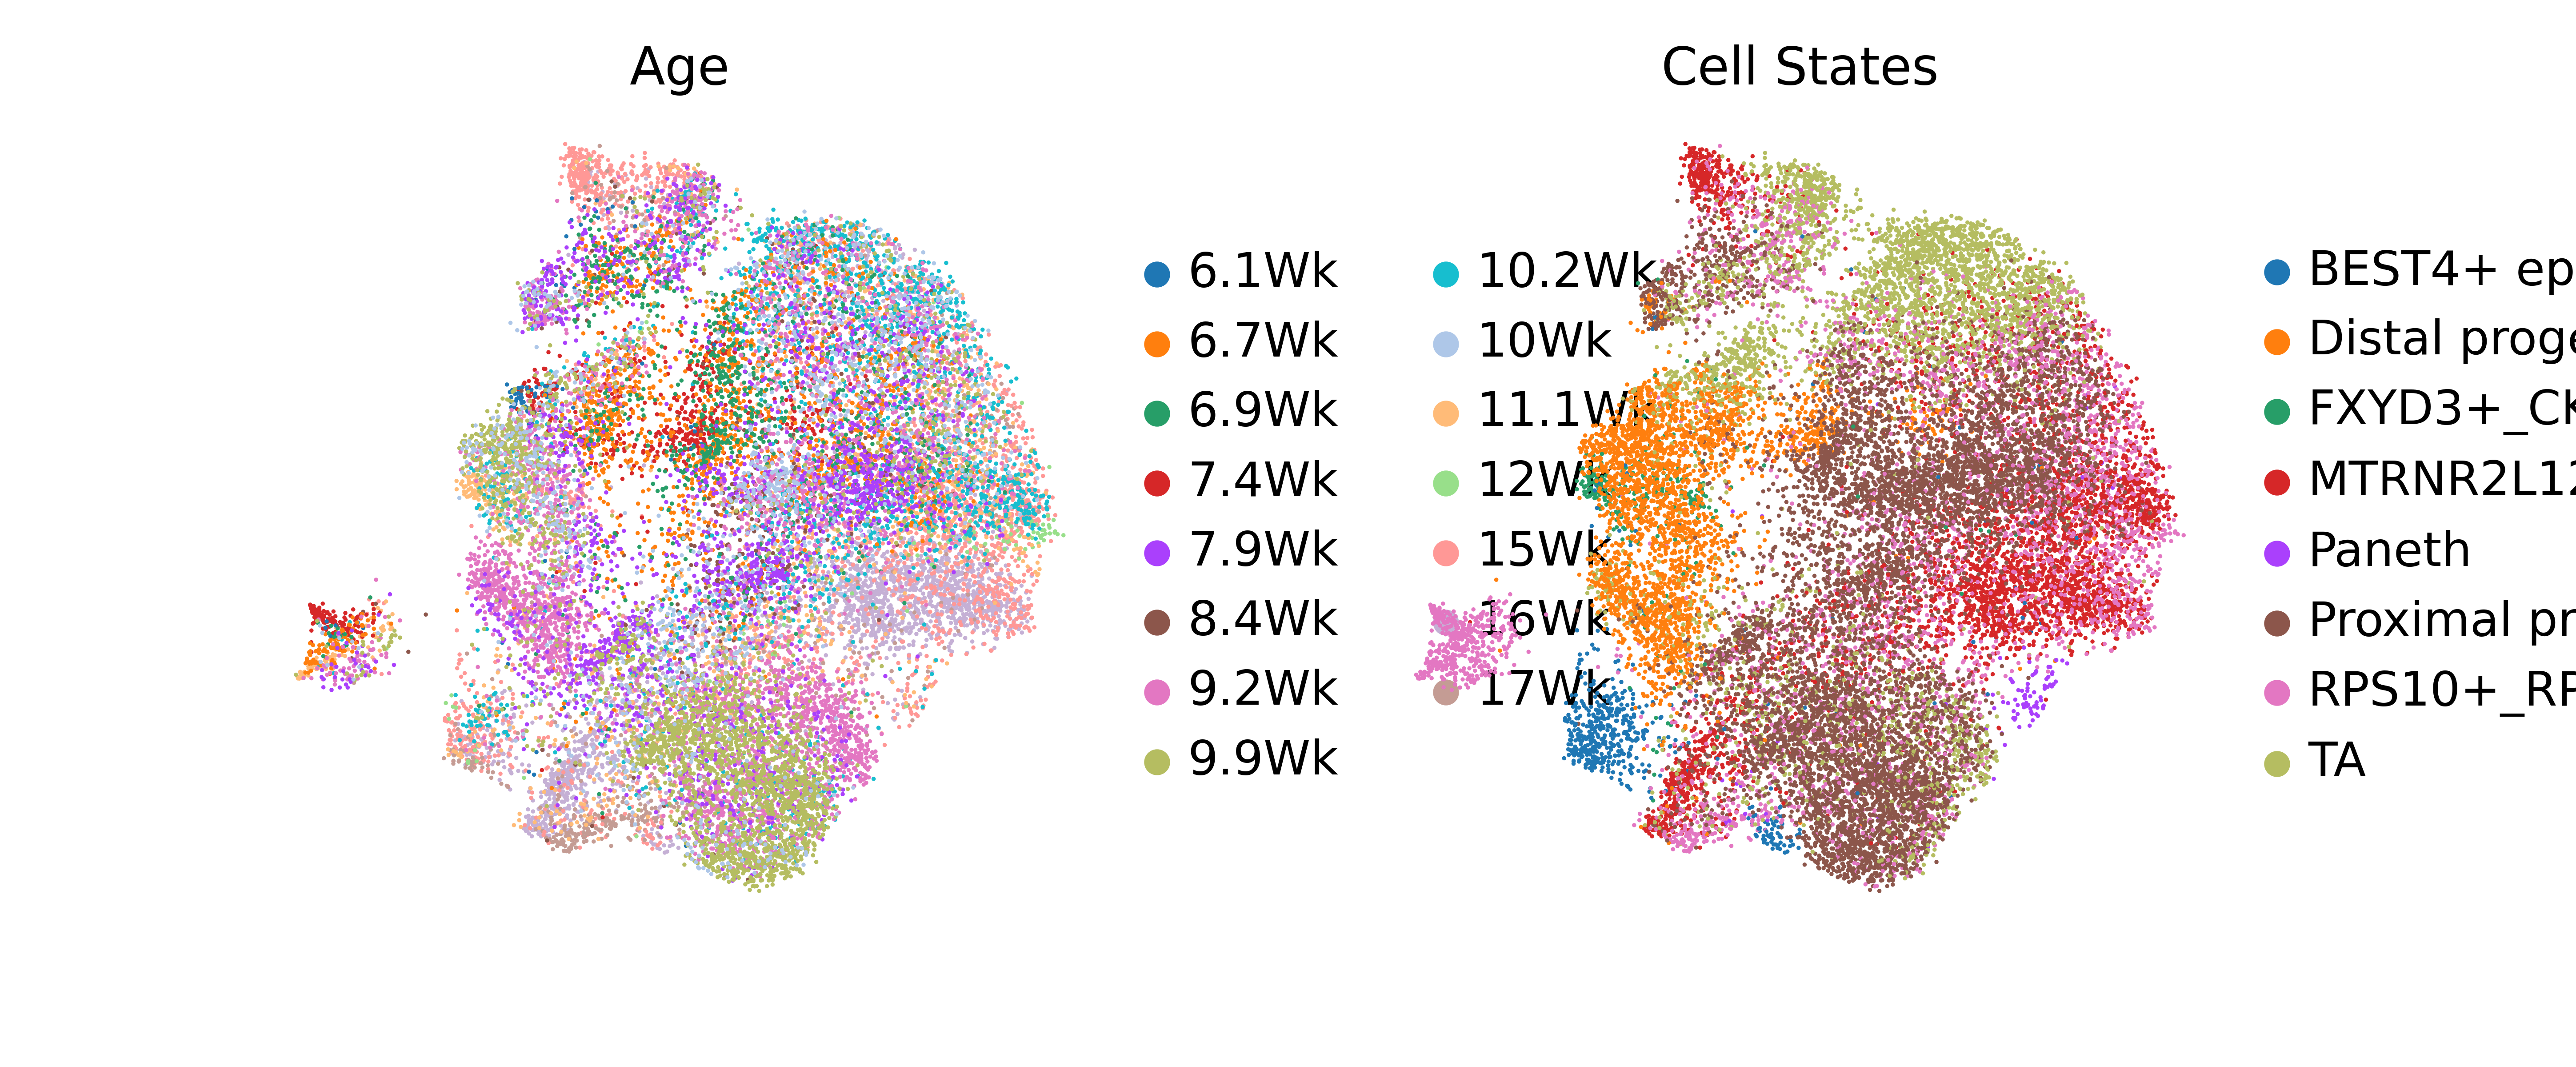

In [48]:
sc.pl.umap(adata, color=['Age', 'Cell States'], frameon=False)

### Ligand-Receptor Inference by Sample

In [49]:
# delete sample with only one cell
adata = adata[adata.obs.groupby('Donor_ID').Donor_ID.transform('size') > 1]

In [50]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby='Cell States',
    sample_key='Donor_ID', # sample key by which we which to loop
    use_raw=False,
    verbose=True, # use 'full' to show all verbose information
    n_perms=None, # exclude permutations for speed
    return_all_lrs=True, # return all LR values
    )

Now running: BRC2026:   0%|                             | 0/16 [00:00<?, ?it/s]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: BRC2029:   6%|█▎                   | 1/16 [00:03<00:45,  3.06s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: BRC2043:  12%|██▋                  | 2/16 [00:05<00:38,  2.77s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: BRC2046:  19%|███▉                 | 3/16 [00:10<00:49,  3.80s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: BRC2049:  25%|█████▎               | 4/16 [00:13<00:42,  3.56s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: BRC2119:  31%|██████▌              | 5/16 [00:17<00:37,  3.41s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: BRC2121:  38%|███████▉             | 6/16 [00:21<00:37,  3.70s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: BRC2133:  44%|█████████▏           | 7/16 [00:27<00:40,  4.52s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: BRC2134:  50%|██████████▌          | 8/16 [00:32<00:37,  4.74s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: BRC2258:  56%|███████████▊         | 9/16 [00:38<00:34,  4.93s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: BRC2259:  62%|████████████▌       | 10/16 [00:43<00:30,  5.10s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: F66:  69%|████████████████▌       | 11/16 [00:46<00:22,  4.53s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: F67:  75%|██████████████████      | 12/16 [00:51<00:17,  4.49s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: F72:  81%|███████████████████▌    | 13/16 [00:53<00:11,  3.88s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: F73:  88%|█████████████████████   | 14/16 [00:59<00:08,  4.48s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: F78:  94%|██████████████████████▌ | 15/16 [01:06<00:05,  5.14s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: F78: 100%|████████████████████████| 16/16 [01:10<00:00,  4.41s/it]


In [ ]:
plot = li.pl.dotplot_by_sample(
    adata=adata,
    colour='magnitude_rank',
    size='lrscore',
    source_labels=['Paneth'],
    target_labels=["FXYD3+_CKB+_SC", "RPS10+_RPS17+_SC", "MTRNR2L12+ASS1+_SC"],
    ligand_complex=[],
    receptor_complex=[],
    sample_key='Donor_ID',
    inverse_colour=True,
    inverse_size=False,
    figure_size=(25, 15),
    size_range=(1, 3),
    cmap='magma_r', 
)

#plot.save(output_dir + '/g.png', height=9, width=9)
plot

In [64]:
adata.uns['liana_res'].to_csv(output_dir + 'undifferentiated_fetal_CCI_liana_aggregate.csv', index=False)

### Building a Tensor

In [65]:
tensor = li.multi.to_tensor_c2c(adata,
                                sample_key='Donor_ID',
                                score_key='magnitude_rank', # can be any score from liana
                                how='outer_cells' # how to join the samples
                                )

100%|██████████████████████████████████████████| 16/16 [01:12<00:00,  4.54s/it]


In [66]:
tensor.tensor.shape

torch.Size([16, 1017, 8, 8])

In [67]:
c2c.io.export_variable_with_pickle(tensor, "/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_undifferentiated_cells/FetalSC_and_undifferentiated_cells_liana_tensor.pkl")

/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_undifferentiated_cells/FetalSC_and_undifferentiated_cells_liana_tensor.pkl  was correctly saved.


+ Build Metadata

In [68]:
context_dict = adata.obs[['Donor_ID', 'Age']].drop_duplicates()
context_dict = dict(zip(context_dict['Donor_ID'], context_dict['Age']))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

### Running Tensor-cell2cell

Running Elbow Analysis


100%|██████████████████████████████████████████| 30/30 [03:03<00:00,  6.10s/it]


The rank at the elbow is: 12
Running Tensor Factorization
Generating Outputs
Loadings of the tensor factorization were successfully saved into /mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_undifferentiated_cells/liana_results/Loadings.xlsx


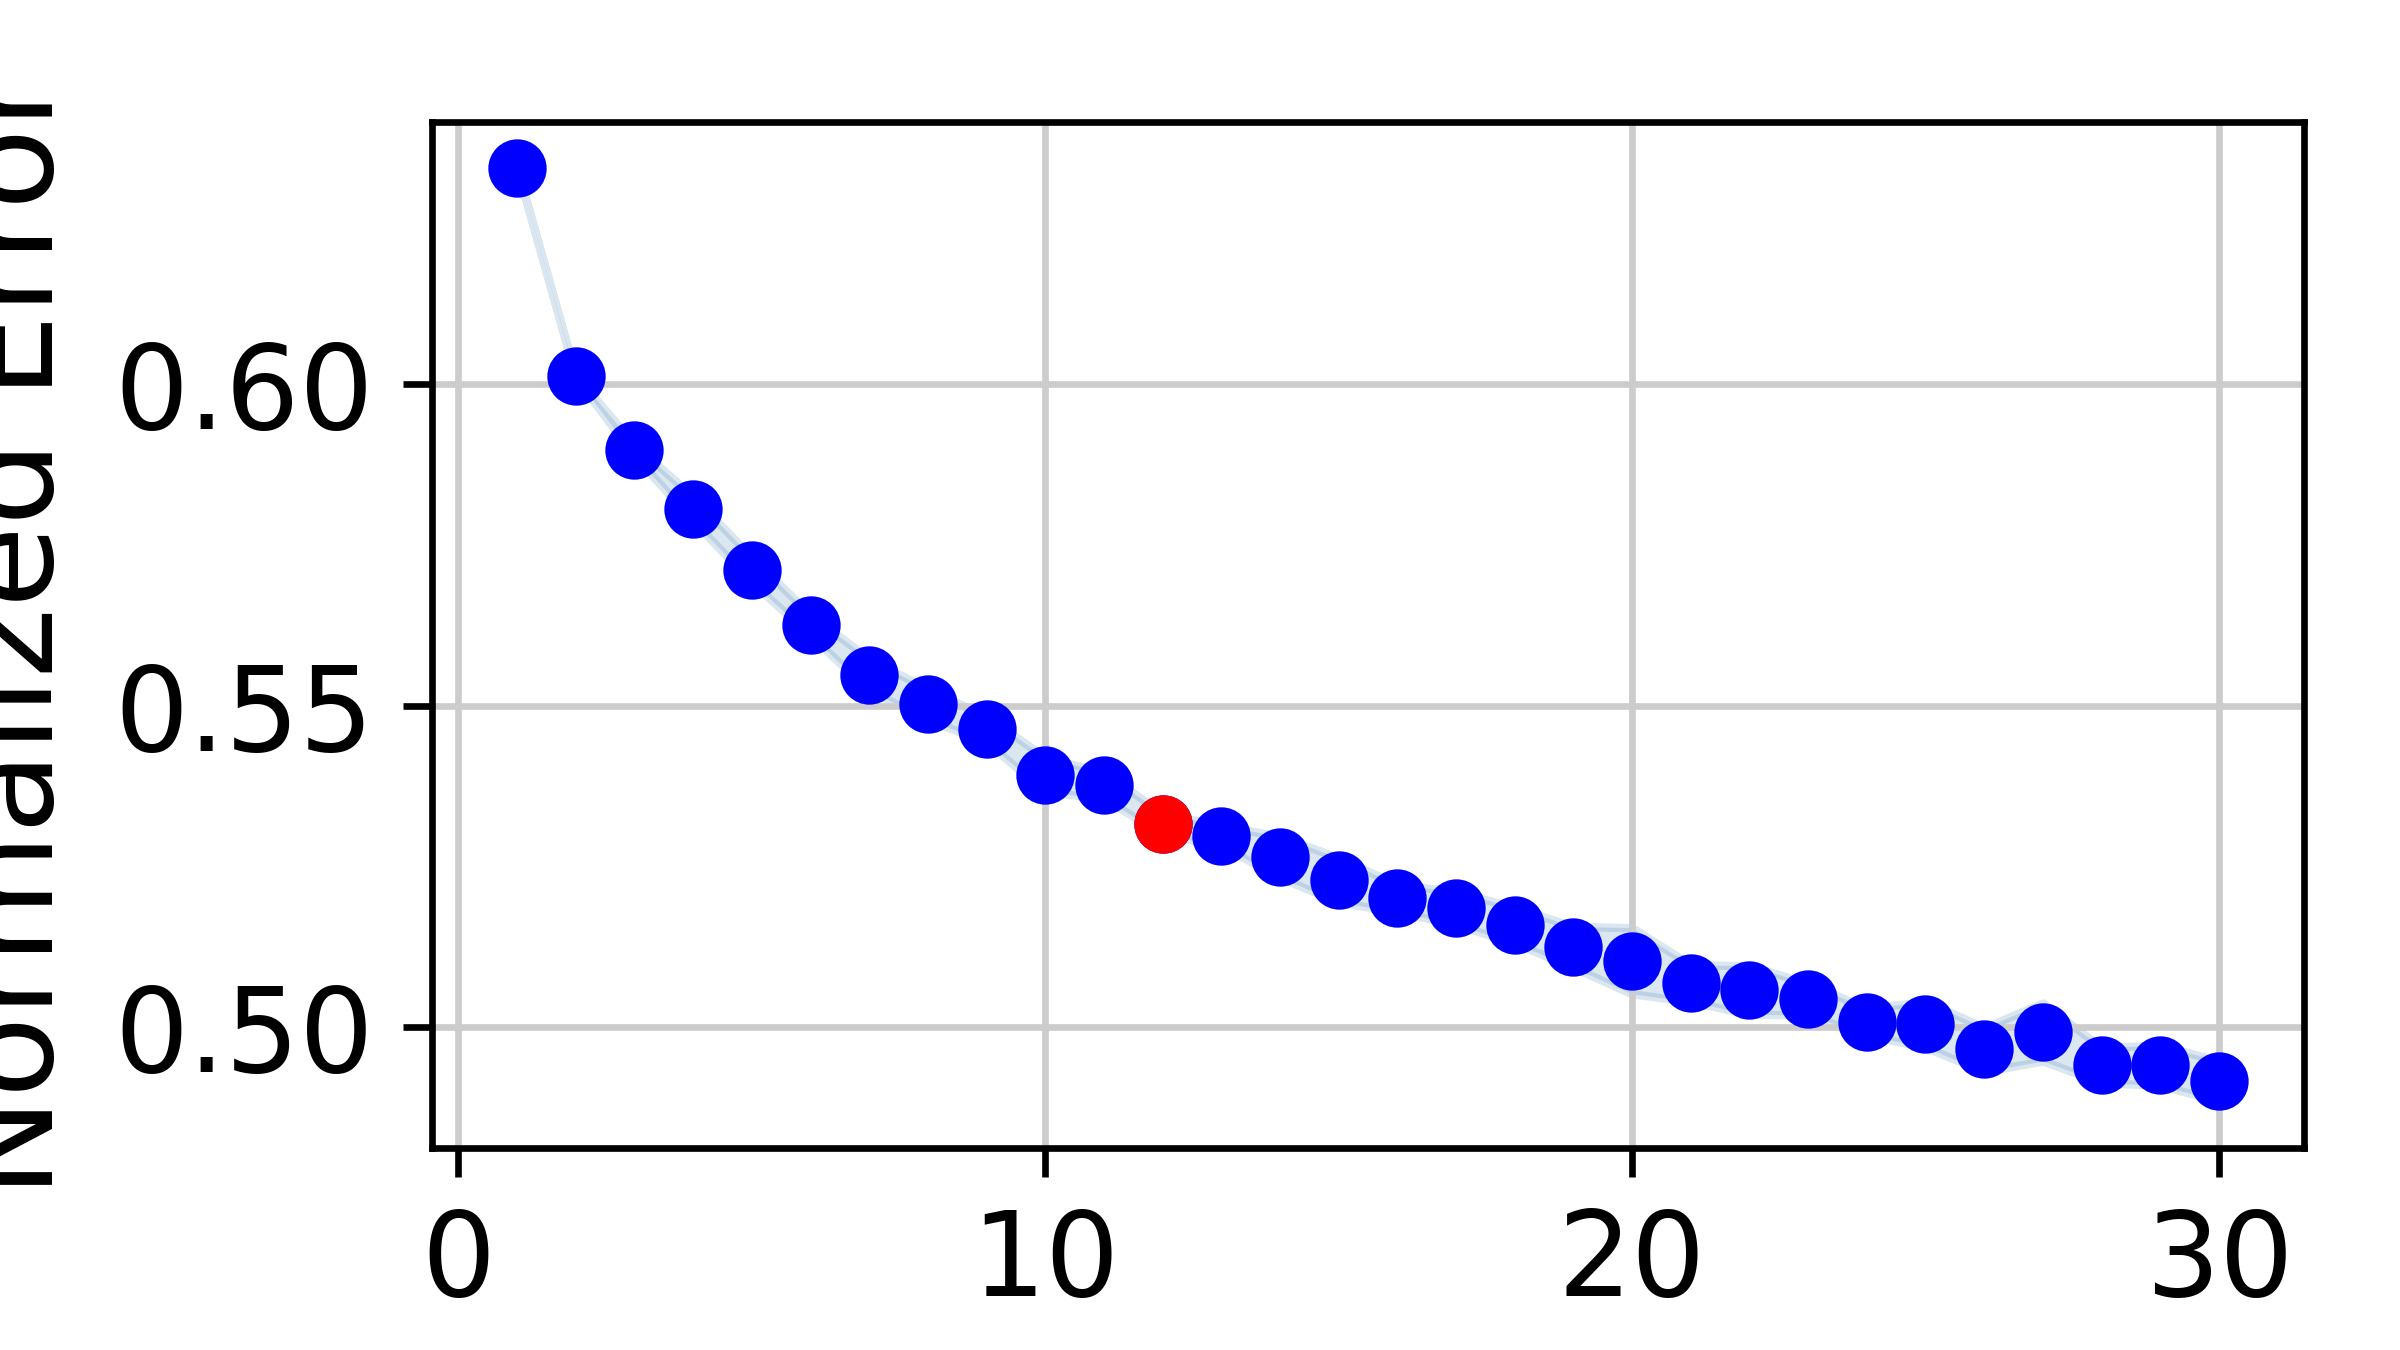

In [69]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=None, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device=device, # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=30, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=["gist_earth", "gray", "terrain", "magma_r" ], # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=True, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    output_folder= output_dir,
                                                    )